In [1]:
import tensorflow as tf
import numpy as np

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

In [3]:
import os
len(os.listdir("/content/dataset/Z"))

3000

In [4]:
import os
import random
import shutil

def create_split(source_folder, destination_folder, train_percent=0.7, val_percent=0.15, test_percent=0.15):
    # Create train, val, test folders
    train_folder = os.path.join(destination_folder, 'train')
    val_folder = os.path.join(destination_folder, 'val')
    test_folder = os.path.join(destination_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate through each class folder (A-Z and nothing)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        os.makedirs(os.path.join(train_folder,class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_folder,class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_folder,class_folder), exist_ok=True)

        if os.path.isdir(class_path):
            # List all files in the class folder
            files = os.listdir(class_path)
            random.shuffle(files)

            # Calculate the number of files for each split
            total_files = len(files)
            train_count = int(train_percent * total_files)
            val_count = int(val_percent * total_files)

            # Split the files into train, val, and test
            train_files = files[:train_count]
            val_files = files[train_count:train_count + val_count]
            test_files = files[train_count + val_count:]

            # Move files to respective split folders
            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, class_folder))

            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, class_folder))

            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, class_folder))

# Example usage
source_dataset_folder = '/content/dataset'
destination_split_folder = '/content/new_data'

create_split(source_dataset_folder, destination_split_folder)


In [5]:
len(os.listdir("/content/new_data/val/A"))

450

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

batch_size = 32
image_height = 224
image_width = 224

train =  "/content/new_data/train"
validation =  "/content/new_data/val"
test =  "/content/new_data/test"

train_generator = datagen.flow_from_directory(
    train,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

validation_generator = datagen.flow_from_directory(
    validation,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    test,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.


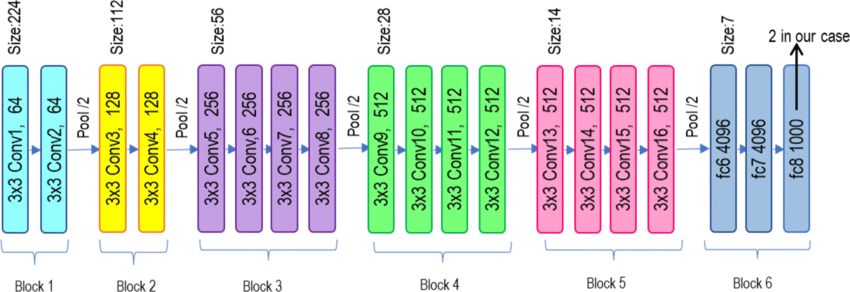

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models


model = Sequential([
                      Conv2D(64,(3,3),input_shape=(image_height, image_width, 3),activation='relu',padding='same',),
                      Conv2D(64,(3,3),activation='relu',padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=(2, 2)),

                      Conv2D(128,(3,3),activation='relu',padding='same'),
                      Conv2D(128,(3,3),activation='relu',padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=(2, 2)),

                      Conv2D(256,(3,3),activation='relu',padding='same'),
                      Conv2D(256,(3,3),activation='relu',padding='same'),
                      Conv2D(256,(3,3),activation='relu',padding='same'),
                      Conv2D(256,(3,3),activation='relu',padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=(2, 2)),

                      Conv2D(512,(3,3),activation='relu',padding='same'),
                      Conv2D(512,(3,3),activation='relu',padding='same'),
                      Conv2D(512,(3,3),activation='relu',padding='same'),
                      Conv2D(512,(3,3),activation='relu',padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=(2, 2)),

                      # Conv2D(512,(3,3),activation='relu',padding='same'),
                      # Conv2D(512,(3,3),activation='relu',padding='same'),
                      # Conv2D(512,(3,3),activation='relu',padding='same'),
                      # Conv2D(512,(3,3),activation='relu',padding='same'),
                      # MaxPooling2D(pool_size=(2, 2)),

                      Flatten(),
                      Dense(4096,activation='relu'),
                      Dropout(0.2),
                      Dense(1024,activation='relu'),
                      Dense(29,activation='softmax')    #29 classes
                  ])

In [8]:
lr0 = 0.001

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        min_delta=1e-2,
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

model.compile(optimizer=tf.keras.optimizers.Adam(lr0),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator)//32,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)//32,
    callbacks = callbacks
)

Epoch 1/100
59/59 [==============================] - 83s 927ms/step - loss: 13.5524 - accuracy: 0.0546 - val_loss: 4.6137 - val_accuracy: 0.0365
Epoch 2/100
59/59 [==============================] - 50s 845ms/step - loss: 3.3757 - accuracy: 0.0429 - val_loss: 3.3727 - val_accuracy: 0.0391
Epoch 3/100
59/59 [==============================] - 50s 853ms/step - loss: 3.3415 - accuracy: 0.0524 - val_loss: 3.3680 - val_accuracy: 0.0260
Epoch 4/100
59/59 [==============================] - 48s 818ms/step - loss: 3.2446 - accuracy: 0.0847 - val_loss: 3.3581 - val_accuracy: 0.0443
Epoch 5/100
59/59 [==============================] - 49s 821ms/step - loss: 3.1998 - accuracy: 0.0842 - val_loss: 3.3459 - val_accuracy: 0.0417
Epoch 6/100
59/59 [==============================] - 49s 832ms/step - loss: 3.1630 - accuracy: 0.0938 - val_loss: 3.3024 - val_accuracy: 0.0807
Epoch 7/100
59/59 [==============================] - 49s 819ms/step - loss: 3.0323 - accuracy: 0.1186 - val_loss: 3.1680 - val_accuracy

#To Do
##-Learning Rate Decay
##-Hyper-parameter Tuning, Layer mods
##-Callbacks
##-Grid/RandomSearch


Observations:

Training no1: 50 epochs, 1e-3 learning rate
 = need more epochs, loss is decreasing

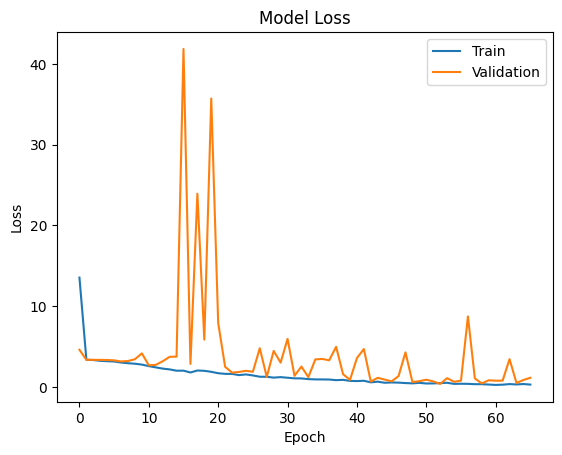

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

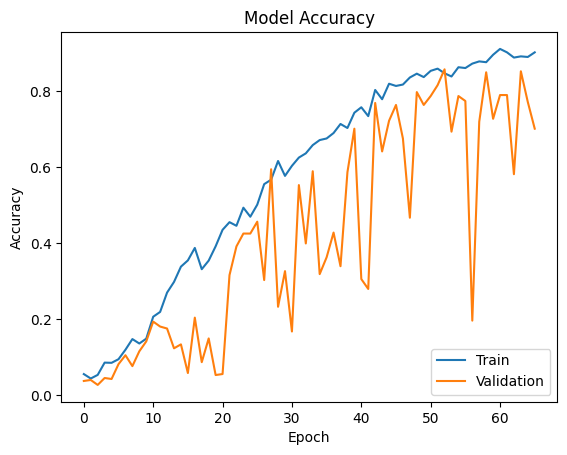

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

In [16]:
model.save_weights('model_weights.h5')
model.save('full_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator

# Load the saved model
# loaded_model = load_model('/content/model_weights.h5')
loaded_model = model
# Define the test data generator
test_data_dir = '/content/new_data/test'
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),  # specify the target size
    batch_size=batch_size,
    class_mode='categorical',  # assuming you have categorical labels
    shuffle=False  # to ensure the predictions are in the same order as the files
)

# Generate predictions on the test data
predictions = loaded_model.predict(test_generator)

# Get true labels
true_labels = test_generator.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate and print the classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

Found 13050 images belonging to 29 classes.
408/408 [==============================] - 61s 149ms/step
Classification Report:
               precision    recall  f1-score   support

           A       0.83      0.92      0.87       450
           B       0.71      0.63      0.67       450
           C       0.97      0.99      0.98       450
           D       0.89      0.86      0.87       450
           E       0.70      0.86      0.77       450
           F       0.76      0.99      0.86       450
           G       0.87      0.80      0.83       450
           H       0.81      0.85      0.83       450
           I       0.89      0.74      0.81       450
           J       0.78      0.94      0.86       450
           K       0.60      0.83      0.69       450
           L       0.92      0.98      0.95       450
           M       0.58      0.35      0.44       450
           N       0.57      0.79      0.66       450
           O       0.90      0.82      0.86       450
         

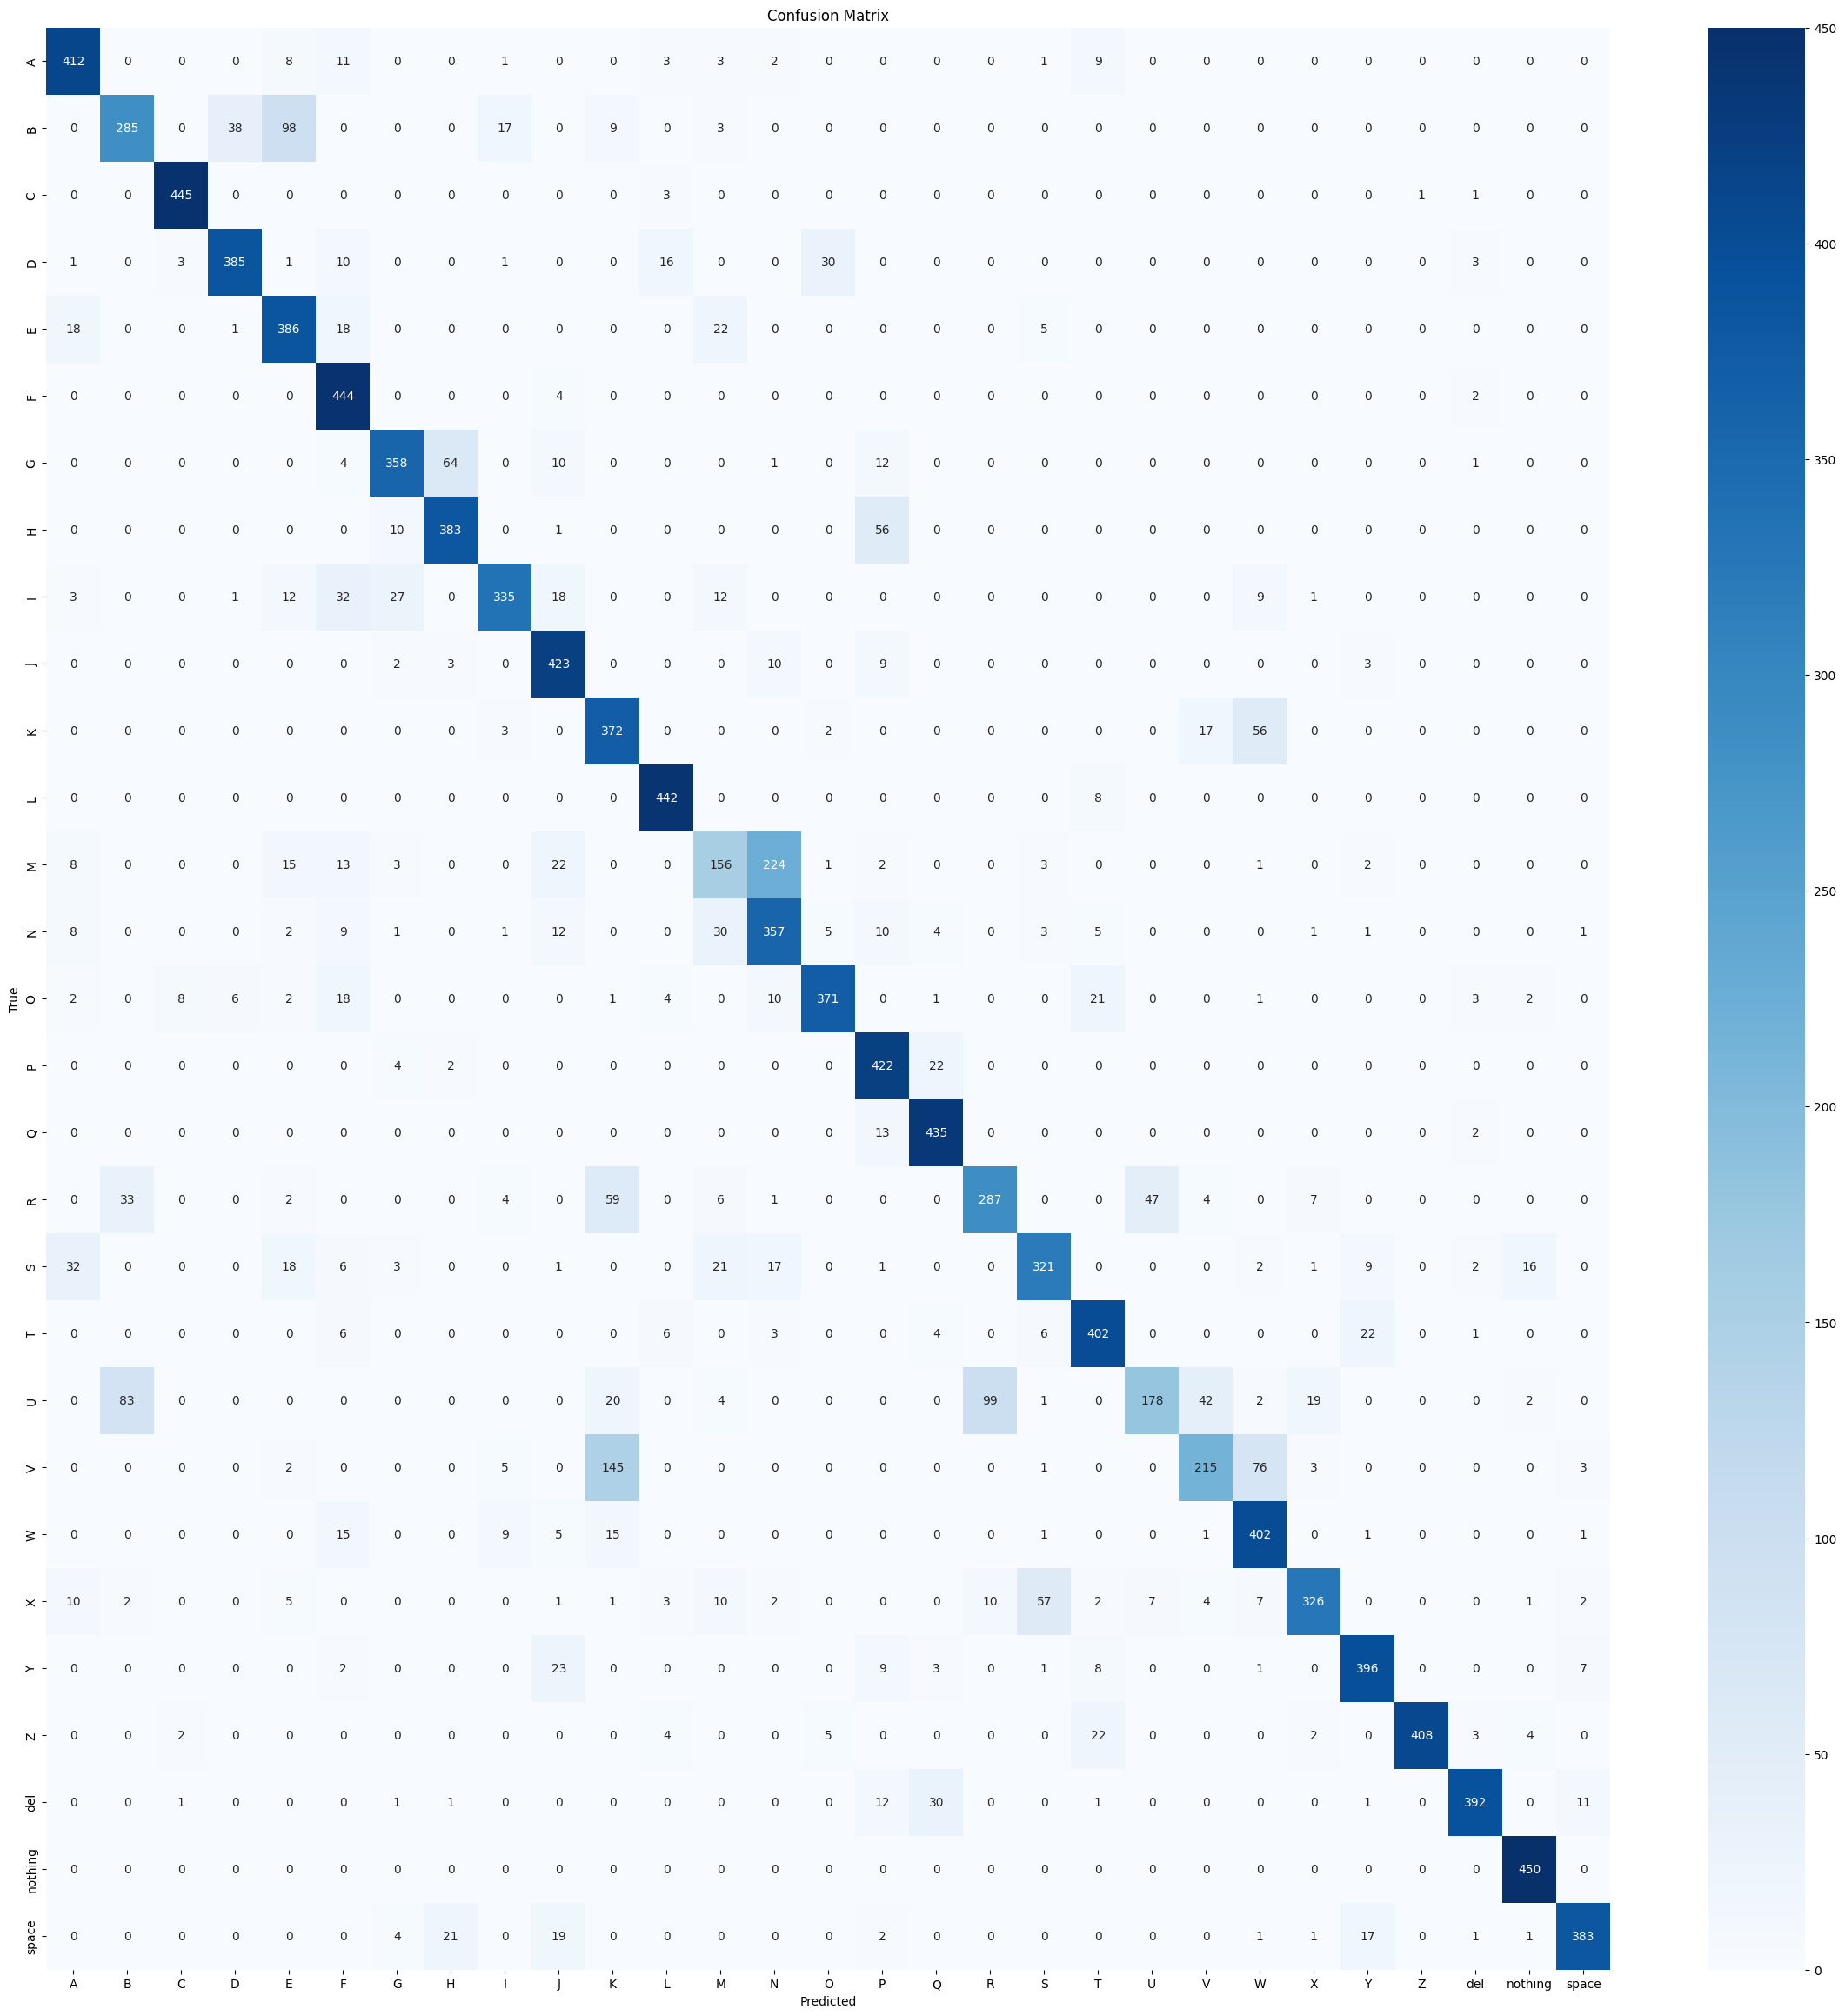

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()